In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import ta
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import DataLoader, random_split

In [2]:
data = yf.download(
    "SPY",
    start="1990-01-01",
    end="2021-01-01",
    auto_adjust = True,
    group_by="Ticker",
)

[*********************100%***********************]  1 of 1 completed


In [4]:
df = ta.utils.dropna(data)
df = ta.add_all_ta_features(df, "Open", "High", "Low", "Close", "Volume", fillna=True)
df['feature_sma_diff'] = df['trend_sma_fast'] - df['trend_sma_slow']
df['feature_ema_diff'] = df['trend_ema_fast'] - df['trend_ema_slow']
df['feature_diff_bbl'] = df['Close'] - df['volatility_bbl']
df['feature_diff_bbh'] = df['volatility_bbh'] - df['Close']

In [7]:
cols = [
    'Open',
    'Close',
    'High',
    'Low',
    'trend_macd_diff',
    'feature_sma_diff',
    'feature_ema_diff',
    'feature_diff_bbl',
    'feature_diff_bbh',
    'momentum_roc',
    'trend_sma_fast',
    'trend_sma_slow',
    'trend_ema_fast',
    'trend_ema_slow',
    'momentum_rsi',
    'trend_cci',
]
df = df[cols]

In [53]:
close_prices = df['Close'].to_numpy()
length = len(close_prices)
window_size = 11
nwindows = length // 11

maxs, mins = set(), set()
for i in range(nwindows):
    start = i * window
    end = start + window
    sub = close_prices[start:end]
    maxs.add(np.argmax(sub)+start)
    mins.add(np.argmin(sub)+start)

labels = []
for i in range(length):
    if i in maxs:
        labels.append(0)
    elif i in mins:
        labels.append(1)
    else:
        labels.append(2)

In [54]:
df['label'] = labels
df

/var/folders/cc/2hgv16qj2r95km6wqkh0r0z80000gn/T/ipykernel_61288/3899639949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = labels


,Open,Close,High,Low,trend_macd_diff,feature_sma_diff,feature_ema_diff,feature_diff_bbl,feature_diff_bbh,momentum_roc,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,momentum_rsi,trend_cci,label
Date,,,,,,,,,,,,,,,,,
1993-01-29,25.735670,25.717379,25.735670,25.607632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.717379,25.717379,25.717379,25.717379,100.000000,0.000000,1
1993-02-01,25.735671,25.900291,25.900291,25.735671,0.011673,0.000000,0.014591,0.274369,0.091456,0.000000,25.808835,25.808835,25.745519,25.730928,100.000000,66.666667,2
1993-02-02,25.881995,25.955160,25.973451,25.827122,0.021853,0.000000,0.030234,0.300865,0.105764,0.000000,25.857610,25.857610,25.777772,25.747538,100.000000,78.123335,2
1993-02-03,25.991757,26.229542,26.247833,25.973465,0.044521,0.000000,0.064033,0.646035,0.088138,0.000000,25.950593,25.950593,25.847275,25.783242,100.000000,124.245320,2
1993-02-04,26.320988,26.339279,26.394153,26.028329,0.063221,0.000000,0.098538,0.763156,0.141258,0.000000,26.028330,26.028330,25.922968,25.824430,100.000000,102.020825,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,364.514223,365.425323,365.455032,363.890351,-0.618904,2.871334,3.737619,7.602089,2.486022,0.108843,363.647199,360.775865,363.664804,359.927185,62.058541,68.414343,2
2020-12-28,368.138779,368.564636,368.980551,367.475286,-0.403916,2.776044,3.851628,10.428268,0.028204,1.882637,364.214742,361.438698,364.418624,360.566996,66.443740,165.077844,2
2020-12-29,370.188721,367.861481,370.376883,367.237579,-0.331662,2.715948,3.840966,8.665116,0.754444,1.721524,364.733546,362.017598,364.948294,361.107329,64.641599,162.750226,2


In [55]:
class StockDataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        raw = self.df.iloc[idx].values
        if type(idx) == int:
            raw = raw.reshape(1, -1)
        data = torch.tensor(raw[:, :-1], dtype=torch.float32)
        label = torch.tensor(raw[:, -1], dtype=torch.long)
        return data, label

In [56]:
chosen = df[50:]
dataset = StockDataset(chosen)

In [57]:
train_data, valid_data = random_split(dataset, [len(dataset)*8//10, len(dataset) - len(dataset)*8//10])

In [58]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [69]:
class StockPredictor(nn.Module):

    def __init__(self, feature_size):
        super(StockPredictor, self).__init__()
        self.m1 = nn.Sequential(
            nn.Linear(feature_size, 256),
            nn.Sigmoid(),
            nn.Linear(256, 512),
            nn.Sigmoid(),
            nn.Linear(512, 256),
            nn.Sigmoid(),
            nn.Linear(256, 128),
            nn.Sigmoid(),
            nn.Linear(128, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.m1(x)
        return out

In [76]:
verbose = False

def train(model, dataloader, criterion, optimizer, epoch):
    model.train()
    train_loss, correct = 0, 0

    for batch, (data, target) in enumerate(dataloader):
        output = model(data.squeeze(1))
        loss = criterion(output, target.squeeze(1))
        train_loss += loss.item()
        # back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate accuracy
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        
        # debug printing
        if batch % 10 == 0 and verbose:
            print('Training Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch * len(data), len(dataloader.dataset),
                100. * batch / len(dataloader), loss.item()
            ))

    train_loss /= len(dataloader.dataset)
    total = len(dataloader.dataset) * batch_size
    accuracy = correct / total

    print(f'Epoch: {epoch}')
    print('Training set: Average loss: {:.4f}, Accuracy {}/{} ({:.0f}%)'.format(
        train_loss, correct, total, 100. * accuracy
    ))

    return (train_loss, accuracy)

def validate(dataloader, model, criterion):
    model.eval()
    valid_loss, correct = 0, 0

    with torch.no_grad():
        for data, target in dataloader:
            output = model(data.squeeze(1))
            valid_loss += criterion(output, target.squeeze(1)).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    valid_loss /= len(dataloader.dataset)
    total = len(dataloader.dataset) * batch_size
    accuracy = correct / total

    print('Validation set: Average loss: {:.4f}, Accuracy {}/{} ({:.0f}%)\n'.format(
        valid_loss, correct, total, 100. * accuracy
    ))

    return (valid_loss, accuracy)

def run(lr, epochs=40):
    print(f'Running for epoch={epochs}, lr={lr} ... ')

    model = StockPredictor(len(df.columns)-1)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     scheduler = StepLR(optimizer, step_size=1, gamma=0.7, verbose=True)

    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    for t in range(epochs):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, t)
        train_losses.append(train_loss)
        train_acc.append(train_accuracy)

        valid_loss, valid_accuracy = validate(valid_loader, model, criterion) 
        valid_losses.append(valid_loss)
        valid_acc.append(valid_accuracy)

#         scheduler.step()

    print('[done]')
    return (model, train_losses, valid_losses, train_acc, valid_acc)

In [77]:
model, train_losses, valid_losses, train_accs, valid_accs = run(lr=0.0001)

Running for epoch=40, lr=0.0001 ... 
Epoch: 0
Training set: Average loss: 0.0490, Accuracy 72164/89376 (81%)
Validation set: Average loss: 0.0462, Accuracy 18361/22352 (82%)

Epoch: 1
Training set: Average loss: 0.0463, Accuracy 72980/89376 (82%)
Validation set: Average loss: 0.0460, Accuracy 18372/22352 (82%)

Epoch: 2
Training set: Average loss: 0.0462, Accuracy 72994/89376 (82%)
Validation set: Average loss: 0.0458, Accuracy 18361/22352 (82%)

Epoch: 3
Training set: Average loss: 0.0461, Accuracy 72980/89376 (82%)
Validation set: Average loss: 0.0458, Accuracy 18361/22352 (82%)

Epoch: 4
Training set: Average loss: 0.0461, Accuracy 72994/89376 (82%)
Validation set: Average loss: 0.0458, Accuracy 18361/22352 (82%)

Epoch: 5
Training set: Average loss: 0.0460, Accuracy 72980/89376 (82%)
Validation set: Average loss: 0.0459, Accuracy 18372/22352 (82%)

Epoch: 6
Training set: Average loss: 0.0460, Accuracy 72980/89376 (82%)
Validation set: Average loss: 0.0458, Accuracy 18361/22352 (82%

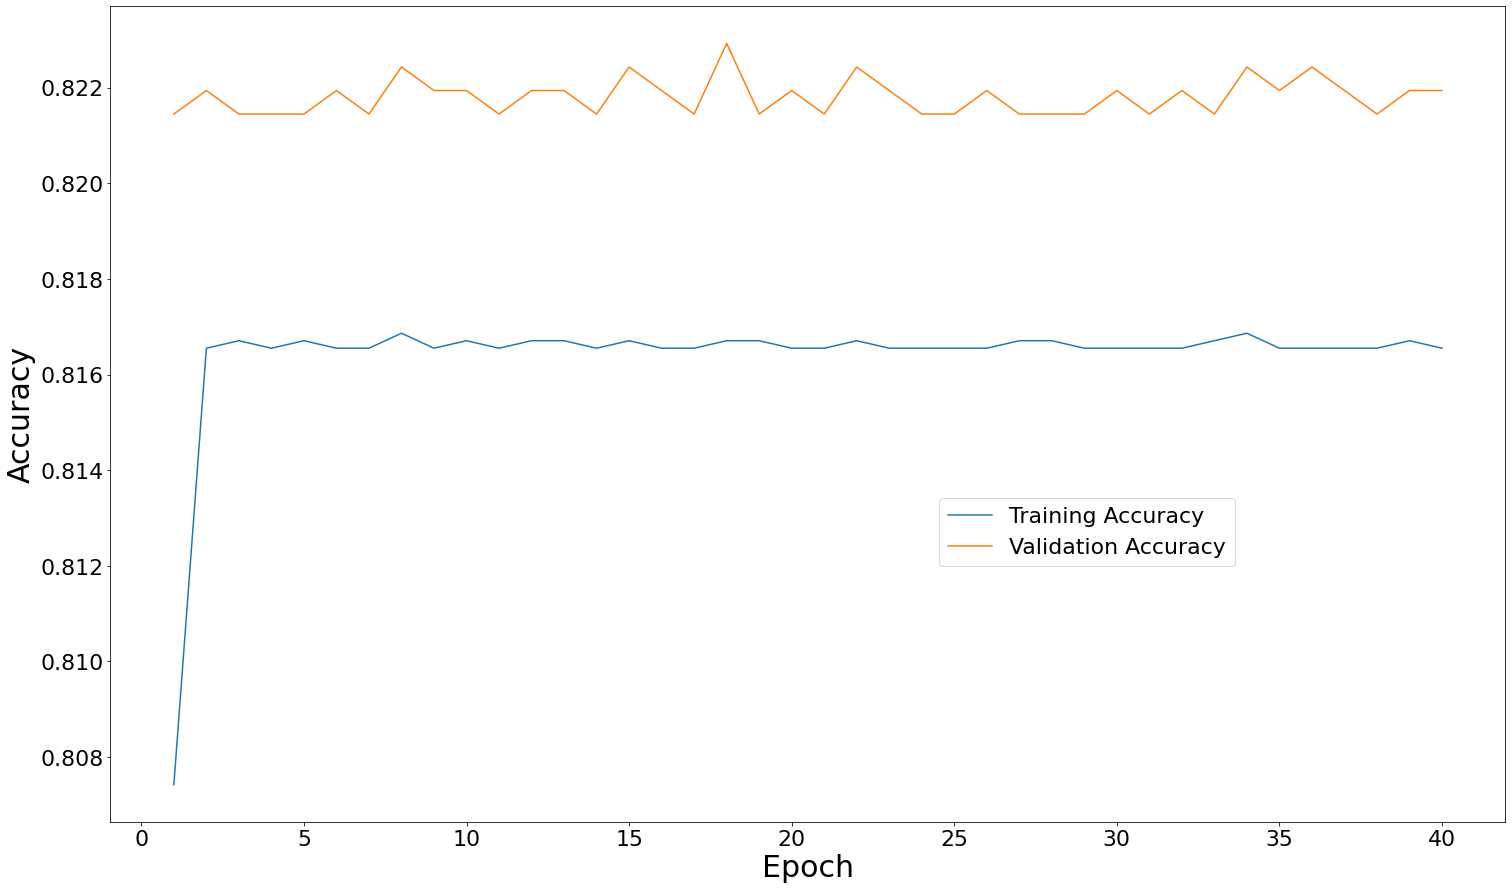

In [78]:
plt.figure(figsize=(25,15))

epoches = list(range(1,len(train_accs)+1))
plt.plot(epoches, train_accs, label='Training Accuracy')
plt.plot(epoches, valid_accs, label='Validation Accuracy')

plt.legend(loc='lower center', bbox_to_anchor=(0.7, 0.3), fontsize=22)
plt.xticks(range(0,41,5), fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Epoch', fontsize=30)
plt.ylabel('Accuracy', fontsize=30)
plt.show()

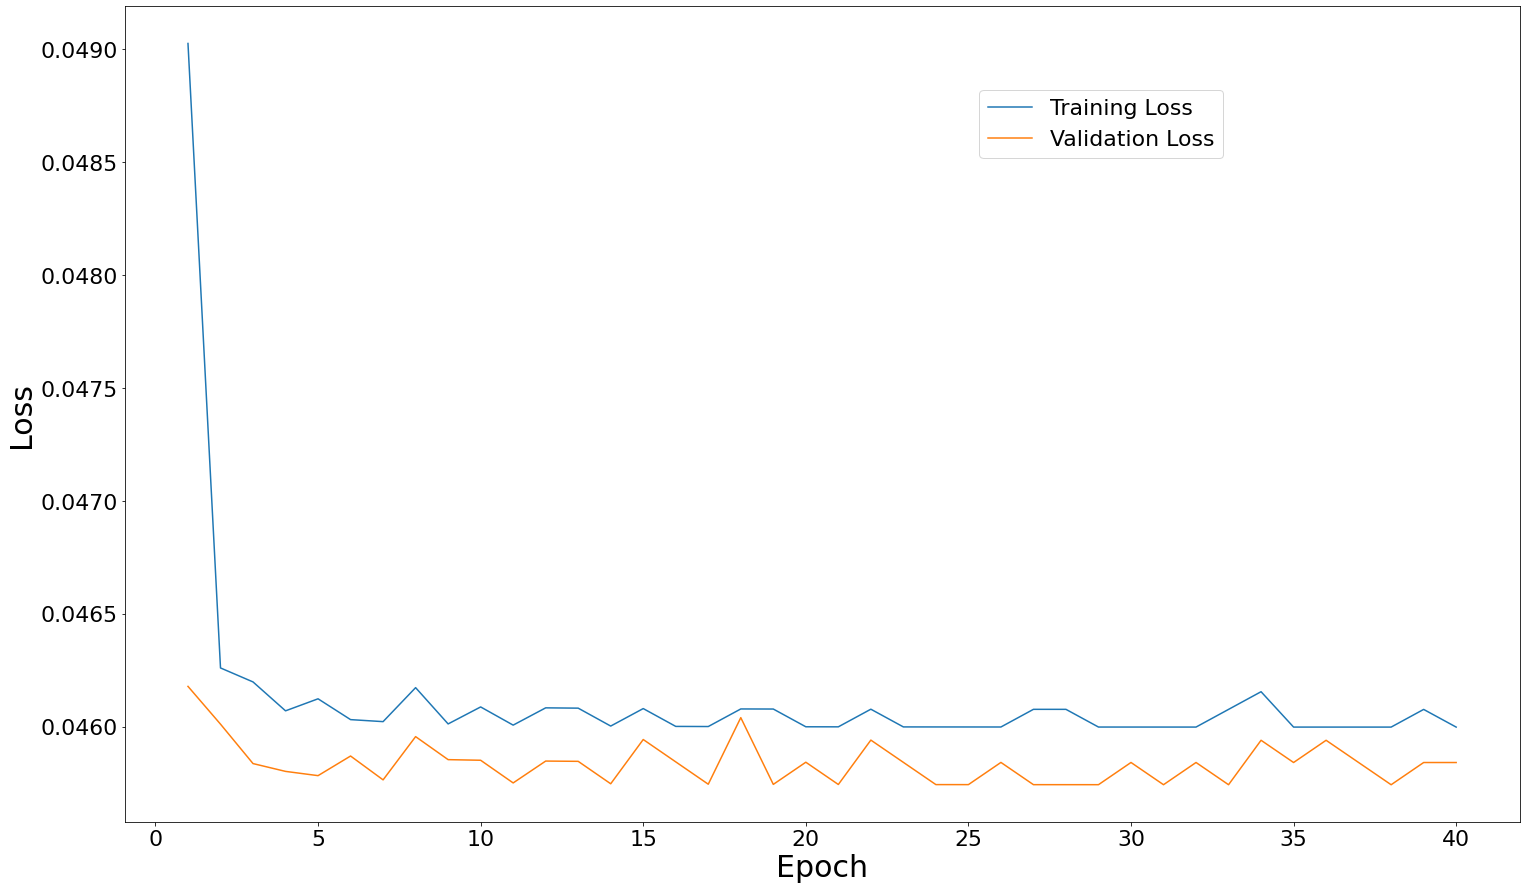

In [79]:
plt.figure(figsize=(25,15))

epoches = list(range(1,len(train_losses)+1))
plt.plot(epoches, train_losses, label='Training Loss')
plt.plot(epoches, valid_losses, label='Validation Loss')

plt.legend(loc='lower center', bbox_to_anchor=(0.7, 0.8), fontsize=22)
plt.xticks(range(0,41,5), fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Epoch', fontsize=30)
plt.ylabel('Loss', fontsize=30)
plt.show()

In [88]:
pred = torch.argmax(model(valid_data[:][0]), dim=1)

In [89]:
torch.bincount(pred)

tensor([   0,    0, 1397])